In [1]:
%load_ext autoreload
%autoreload 2

import os
os.environ['KMP_WARNINGS'] = 'off'
import sys
import git

import uproot as ut
import awkward as ak
import numpy as np
import math
import vector
import sympy as sp

import re
from tqdm import tqdm
import timeit
import re

sys.path.append( git.Repo('.', search_parent_directories=True).working_tree_dir )
from utils import *

In [3]:
tree = Tree(
    [
        '/eos/uscms/store/user/srosenzw/sixb/ntuples/Summer2018UL/maxbtag_mmmm/Official_NMSSM/NMSSM_XToYHTo6B_MX-700_MY-300_TuneCP5_13TeV-madgraph-pythia8/ntuple.root'
    ]
)

100%|██████████| 1/1 [00:01<00:00,  1.04s/it]


In [79]:
from utils.rootUtils.TEfficiency import TEfficiency

fname = '/uscms_data/d3/ekoenig/8BAnalysis/analysis/CMSSW_10_6_28/src/MultiHiggs/analysis/MultiHAnalysis/data/btag/efficiency/sixb/eff_wp_deepJet_2018.root'

b_eff = TEfficiency.from_root(fname, 'eff/medium_hf5_jet_pt_eta')
c_eff = TEfficiency.from_root(fname, 'eff/medium_hf4_jet_pt_eta')
guds_eff = TEfficiency.from_root(fname, 'eff/medium_hf0_jet_pt_eta')

In [80]:
from pandas import read_csv

sf_file = '/uscms/home/srosenzw/nobackup/workarea/higgs/sixb_analysis/CMSSW_10_6_19_patch2/src/MultiHiggs/analysis/MultiHAnalysis/data/btag/2018/wp_deepJet_BTVPOG.csv'
sf_data = read_csv(sf_file)
medium_mask = sf_data['OperatingPoint'] == 'M'
central_mask = sf_data['sysType'] == 'central'
comb_mask = sf_data['measurementType'] == 'comb'
incl_mask = sf_data['measurementType'] == 'incl'
bFlav_mask = sf_data['jetFlavor'] == 5
cFlav_mask = sf_data['jetFlavor'] == 4
gudsFlav_mask = sf_data['jetFlavor'] == 0

b_mask = medium_mask & central_mask & comb_mask & bFlav_mask
c_mask = medium_mask & central_mask & comb_mask & cFlav_mask
guds_mask = medium_mask & central_mask & incl_mask & gudsFlav_mask

b_eqn = sf_data[b_mask]['formula'].iloc[0]
c_eqn = sf_data[c_mask]['formula'].iloc[0]
guds_eqn = sf_data[guds_mask]['formula'].iloc[0]

In [81]:
jet_btag = tree.jet_btag
jet_pt = tree.jet_pt
jet_eta = tree.jet_eta
jet_hadronFlav = tree.jet_hadronFlav
# jet_tagged = ak.argsort(ak.argsort(-jet_btag, axis=1)) < 4
jet_tagged = jet_btag > jet_btagWP[2]

X = (jet_pt, jet_eta, )

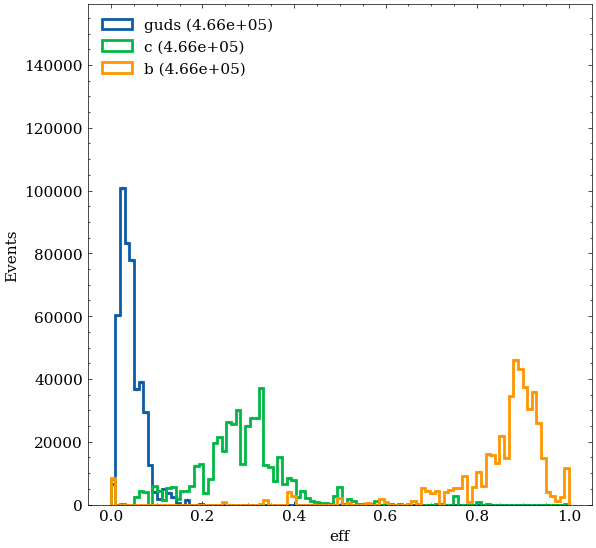

In [82]:
jet_b_eff = b_eff.GetEfficiency(*X)
jet_c_eff = c_eff.GetEfficiency(*X)
jet_guds_eff = guds_eff.GetEfficiency(*X)


hist_multi([jet_guds_eff, jet_c_eff, jet_b_eff], bins=(0,1,100), h_label=['guds', 'c', 'b'], legend=True, xlabel='eff');

In [83]:
jet_eff = ak.where(
    jet_hadronFlav == 5, jet_b_eff,
ak.where(
    jet_hadronFlav == 4, jet_c_eff, jet_guds_eff
))

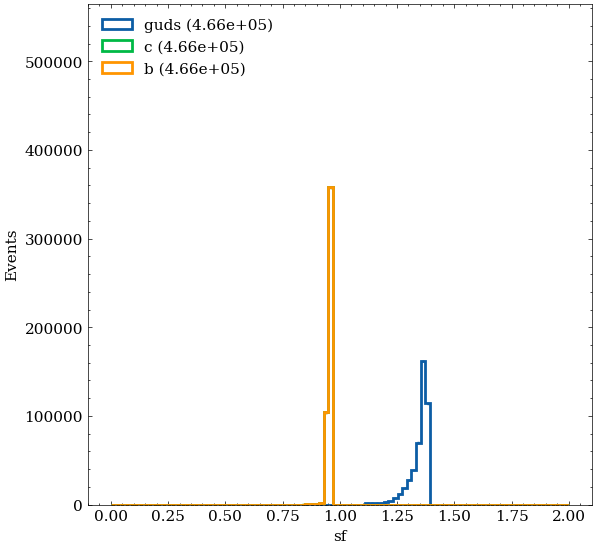

In [84]:
jet_guds_sf = eval(guds_eqn, dict(log=np.log, x=jet_pt))
jet_c_sf = eval(c_eqn, dict(log=np.log, x=jet_pt))
jet_b_sf = eval(b_eqn, dict(log=np.log, x=jet_pt))

hist_multi([jet_guds_sf, jet_c_sf, jet_b_sf], bins=(0,2,100), h_label=['guds', 'c', 'b'], legend=True, xlabel='sf');

In [85]:
jet_sf = ak.where(
    jet_hadronFlav == 5, jet_b_sf,
ak.where(
    jet_hadronFlav == 4, jet_c_sf, jet_guds_sf
))

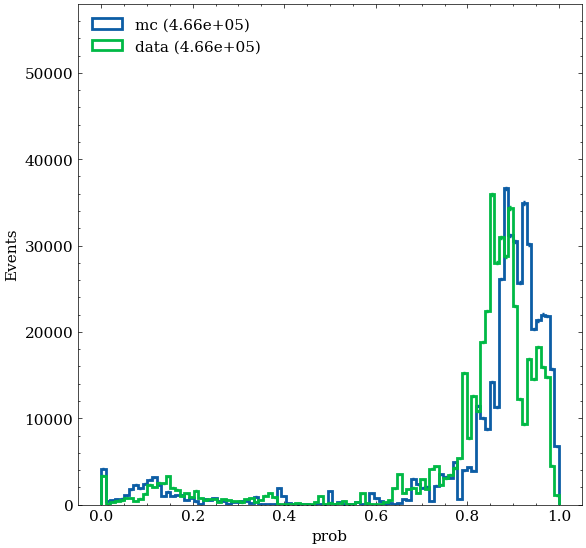

In [86]:
jet_prob_mc = ak.where(jet_tagged, jet_eff, 1-jet_eff)
jet_prob_data = ak.where(jet_tagged, jet_eff*jet_sf, 1-jet_eff*jet_sf)

hist_multi([jet_prob_mc, jet_prob_data], bins=(0,1,100), h_label=['mc', 'data'], legend=True, xlabel='prob');

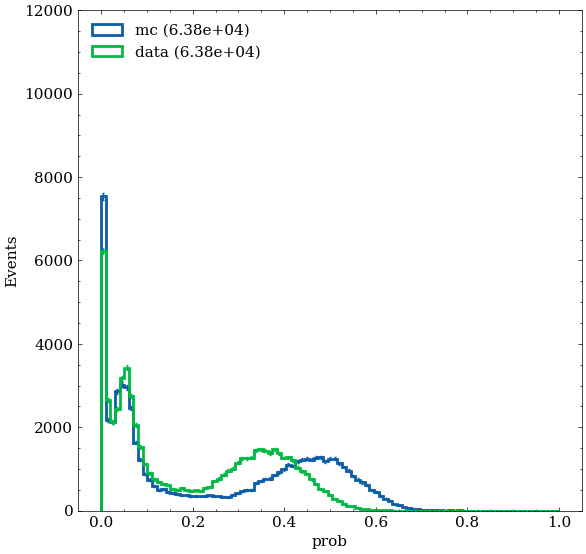

In [87]:
prob_mc = ak.prod(jet_prob_mc, axis=1)
prob_data = ak.prod(jet_prob_data, axis=1)

hist_multi([prob_mc, prob_data], bins=(0,1,100), h_label=['mc', 'data'], legend=True, xlabel='prob');

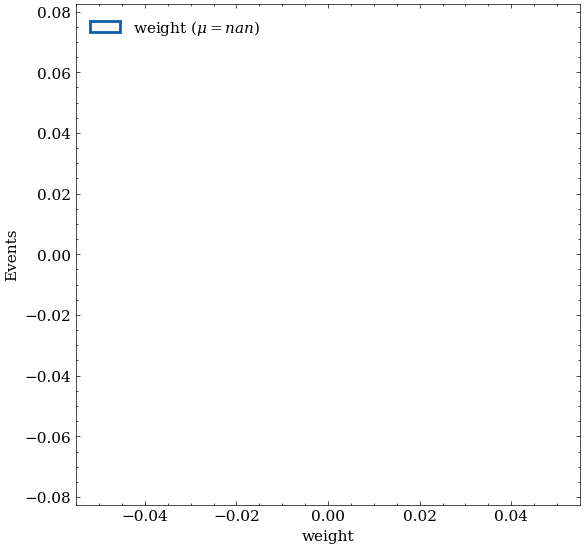

In [88]:
weight = prob_data/prob_mc

hist_multi([weight], h_label=['weight'], legend=True, xlabel='weight', h_label_stat='mean');

In [89]:
jet_btagWP[2]

0.2783

ValueError: zero-size array to reduction operation minimum which has no identity

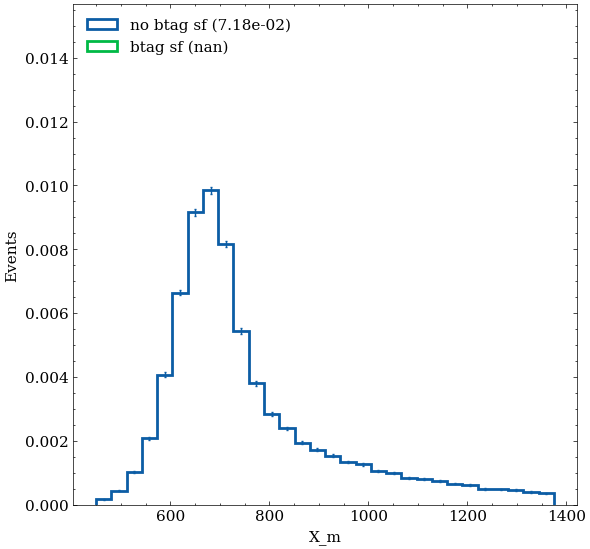

In [90]:
hist_multi([tree.X_m, tree.X_m], weights=[tree.scale, tree.scale * weight], bins=(450,1375,31), h_label=['no btag sf', 'btag sf'], legend=True, xlabel='X_m', ratio=True, r_ylim=(0.8,1.2));